In [1]:
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import unet_Linear as unet

pathdir = './papermodels/Jnetmodels/'

In [4]:
net1 = unet.UNet(depth=3, wf=1, acti_func='relu')
net1.load_state_dict(torch.load(pathdir+'NLModule_3layer_data[11, 12].pt'))
net1.eval()
net1 = net1.double()

net2 = unet.UNet(depth=6, wf=1, acti_func='relu')
net2.load_state_dict(torch.load(pathdir+'NLModule_6layer_data[11, 12].pt'))
net2.eval()
net2 = net2.double()
'''
net3 = unet.UNet(depth=6, wf=1, acti_func='identity')
net3.load_state_dict(torch.load(pathdir+'LinearModule_6layer_10Kdata[4, 5].pt'))
net3.eval()
net3 = net3.double()

net4= unet.UNet(depth=6, wf=1, acti_func='relu')
net4.load_state_dict(torch.load(pathdir+'NLModule_6layer_2Kdata[4, 5].pt'))
net4.eval()
net4 = net4.double()

net5= unet.UNet(depth=6, wf=1, acti_func='relu')
net5.load_state_dict(torch.load(pathdir+'NLModule_6layer_5Kdata[4, 5].pt'))
net5.eval()
net5 = net5.double()

net6= unet.UNet(depth=6, wf=1, acti_func='relu')
net6.load_state_dict(torch.load(pathdir+'NLModule_6layer_10Kdata[4, 5].pt'))
net6.eval()
net6 = net6.double()
'''            
netlist = ((r'JNet 3-level',net1),\
           (r'JNet 6-level',net2),\
           #(r'lin. 10K data',net3),\
           #(r'relu 2K data',net4),\
           #(r'relu 5K data',net5),(r'relu 10K data',net6)\
          )
           

Text(0, 0.5, 'counts')

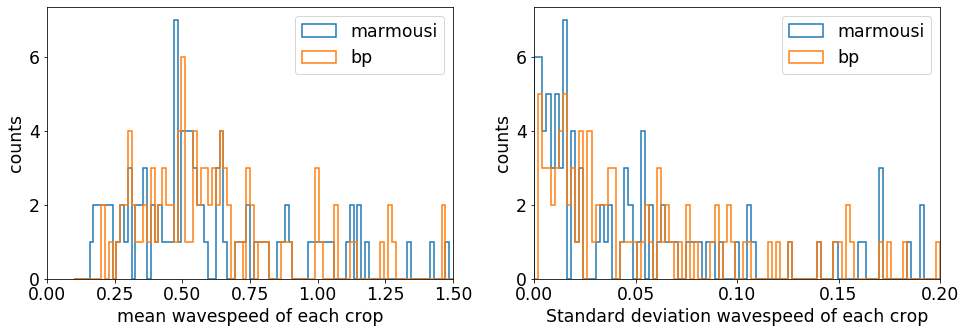

In [4]:
fig = plt.figure(figsize=(16,5))
veldir = './papermodels/'
#marmvel = np.load('./papermodels/marm310cropsM100.npz')
marmvel = np.load(veldir+'mabp310cropsM100.npz')
bpvel = np.load(veldir+'bp310cropsM100.npz')

mmean = marmvel['wavespeedlist'].mean()

ax1 = fig.add_subplot(1,2,1)
pos1= ax1.hist(marmvel['wavespeedlist'].mean((1,2)),bins=np.linspace(0.1,1.5,100),histtype='step',linewidth=1.5)
pos1= ax1.hist(bpvel['wavespeedlist'].mean((1,2)),bins=np.linspace(0.1,1.5,100),histtype='step',linewidth=1.5)
plt.xlim([0,1.5])
ax1.set_xlabel('mean wavespeed of each crop')
ax1.legend([r'marmousi',r'bp'])
ax1.set_ylabel('counts')

ax2 = fig.add_subplot(1,2,2)
pos2= ax2.hist(marmvel['wavespeedlist'].std((1,2)),bins=np.linspace(0.,0.2,100),histtype='step',linewidth=1.5)
pos2= ax2.hist(bpvel['wavespeedlist'].std((1,2)),bins=np.linspace(0.,0.2,100),histtype='step',linewidth=1.5)
plt.xlim([0,0.2])
ax2.set_xlabel('Standard deviation wavespeed of each crop')
ax2.legend([r'marmousi',r'bp'])
ax2.set_ylabel('counts')
#plt.savefig('./figures/trainingD1D2.eps')

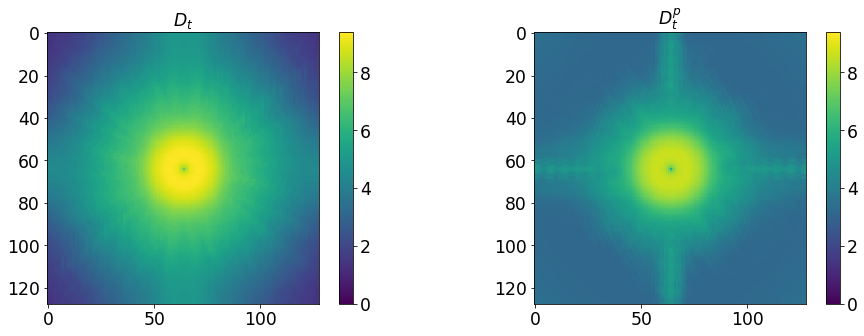

In [5]:
fig = plt.figure(figsize=(16,5))
wavestat = np.load('./wavefieldstatistics.npz')
total_F = np.log10(np.fft.fftshift(wavestat['total_F']))
total_Fp = np.log10(np.fft.fftshift(wavestat['total_Fp']))

vmax_F = np.max(total_F)
ax1 = fig.add_subplot(1,2,1)
pos1= ax1.imshow(total_F,vmin=0,vmax = vmax_F)
#ax1.set_xlim([44,84])
#ax1.set_ylim([44,84])
ax1.set_title(r'$D_t$')
plt.colorbar(pos1)

ax2 = fig.add_subplot(1,2,2)
pos2= ax2.imshow(total_Fp,vmin=0,vmax = vmax_F)
#ax2.set_xlim([44,84])
#ax2.set_ylim([44,84])
ax2.set_title(r'$D^p_t$')
plt.colorbar(pos2)
#plt.savefig('./figures/wavestats.eps')

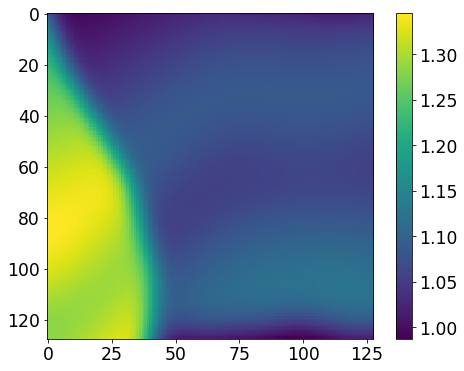

In [66]:
plt.imshow(bpvel['wavespeedlist'][np.random.randint(100)])
plt.colorbar()

## Generalization error as a function of sharpness and wavespeed

In [5]:
import WaveUtil
import wave2
import WavePostprocess as wp
from skimage.transform import resize

In [6]:
cT = 0.2
dx = 2.0/128.0
dt = dx/20
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)
center = np.array([0.,0.])
delc = np.arange(-0.9,2.,0.1)
wlist = np.arange(5,20.0,1)

m=2
ny = round(yy.shape[0]/m)
nx = round(xx.shape[1]/m)

vel = 1+0.*xx

0.017198767821439007
0.012040725907550094


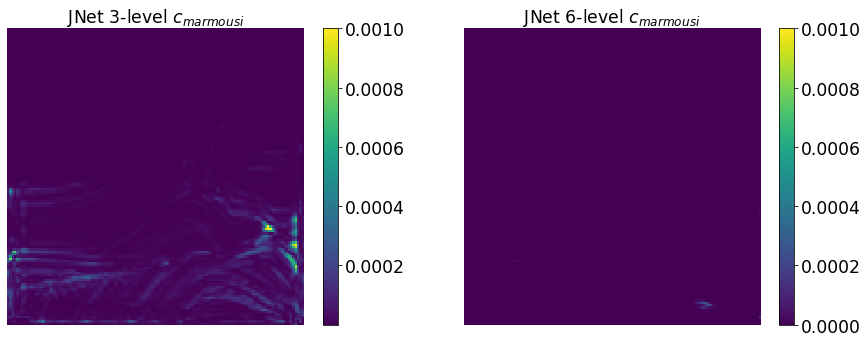

In [15]:
u0 = np.zeros([int(np.size(xx,axis=1)/2),int(np.size(yy,axis=0)/2)])
ut0 = np.zeros([int(np.size(xx,axis=1)/2),int(np.size(yy,axis=0)/2)])
fig = plt.figure(figsize=(15,12))
i = 1
#vel = 1 + np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = resize(datamarm['marm1smal'],[128,128])/4
#vel = resize(databp['Vsmall'],[128,128])/4
for netname,modl in netlist:
    corrected_uc,corrected_utc = wp.ApplyJNet2WaveSol(u0,ut0,vel,dx,modl)
    plt.subplot(2,2,i)
    plt.imshow(WaveUtil.WaveEnergyField(corrected_uc,corrected_utc,vel,dx),vmax = 1e-3)
    plt.colorbar()
    plt.axis('off')
    plt.title(netname+r' $c_{marmousi}$')
    print(np.max(corrected_utc))
    i +=1
    
#plt.savefig('./ghostJnet02_marm.eps',bbox_inches = "tight")

In [7]:
errorlist = np.zeros([6,len(delc),len(wlist)])
idx = 0
for netname,modl in netlist:
    w1error = np.zeros([len(delc),len(wlist)])
    for j in range(len(wlist)):
        u0 = np.exp(-wlist[j]**2*((xx-center[0])**2 + (yy-center[1])**2))
        ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])

        u0,ut0 = wave2.wave2(u0,ut0,vel,dx,dt,0.2)

        for i in range(len(delc)):
            veld = vel+delc[i]
            #if netname in 'relu-parareal 0.2cT': cT = 0.2
            #else: cT = 0.1
            
            uc,utc = wave2.wave2(resize(u0,[ny,nx],order=4),resize(ut0,[ny,nx],order=4),resize(veld,[ny,nx],order=4),dx*m,dt*8,cT)
            #uc = resize(uc,u0.shape,order=4)
            #utc = resize(utc,u0.shape,order=4)
            uf,utf = wave2.wave2(u0,ut0,veld,dx,dt,cT)
            corrected_uc,corrected_utc = wp.ApplyJNet2WaveSol(uc,utc,veld,dx,modl)

            energyuf = np.sum(WaveUtil.WaveEnergyField(uf,utf,veld,dx))
            energyerrorfield = WaveUtil.WaveEnergyField(uf-corrected_uc,utf-corrected_utc,veld,dx)/energyuf
            w1error[i,j] = np.sum(energyerrorfield)
    print(netname)    
    errorlist[idx,:,:] = w1error
    idx += 1

C:\Users\huuhi\.julia\conda\3\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


linear 2K data
linear 5K data
Linear 10K data
relu 2K data
relu 5K data
relu 10K data


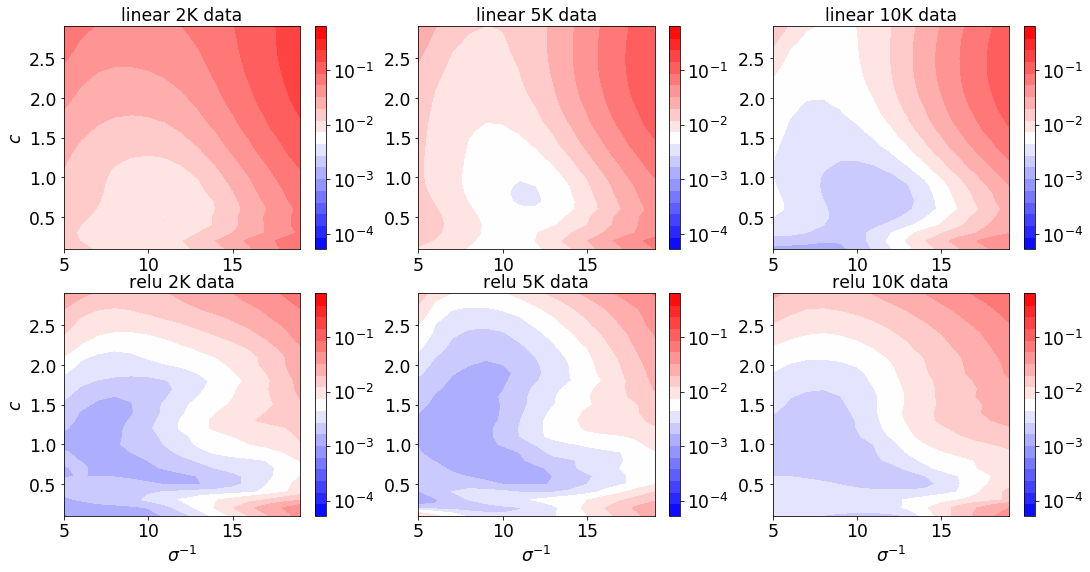

In [15]:
X,Y = np.meshgrid(wlist,delc)
fig = plt.figure(figsize=(18,9))
cmap= 'bwr'
from matplotlib import colors

lev_exp = np.linspace((np.log10(w1error.min()))-1.5,np.ceil(np.log10(w1error.max()))+0.8,20)
levs = np.power(10, lev_exp)
colorticks = [10**-4,10**-3,10**-2,10**-1]

ax1 = fig.add_subplot(2,3,1)
pos1 = ax1.contourf(X,1+Y,errorlist[0,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
#ax1.set_xlabel(r'$\sigma^{-1}$')
ax1.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[0][0])

ax2 = fig.add_subplot(2,3,4) 
pos2 = ax2.contourf(X,1+Y,errorlist[3,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
ax2.set_xlabel(r'$\sigma^{-1}$')
ax2.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[3][0])

ax3 = fig.add_subplot(2,3,2) 
pos3 = ax3.contourf(X,1+Y,errorlist[1,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
#ax1.set_xlabel(r'$\sigma^{-1}$')
#ax1.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[1][0])

ax4 = fig.add_subplot(2,3,5) 
pos4 = ax4.contourf(X,1+Y,errorlist[4,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
ax4.set_xlabel(r'$\sigma^{-1}$')
#ax1.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[4][0])

ax5 = fig.add_subplot(2,3,3) 
pos5 = ax5.contourf(X,1+Y,errorlist[2,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
#ax1.set_xlabel(r'$\sigma^{-1}$')
#ax1.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[2][0])

ax6 = fig.add_subplot(2,3,6) 
pos6 = ax6.contourf(X,1+Y,errorlist[5,:,:],levels=levs,norm=colors.LogNorm(),cmap = cmap)
ax6.set_xlabel(r'$\sigma^{-1}$')
#ax1.set_ylabel(r'$c$')
fig.colorbar(pos1, ticks=colorticks)
plt.title(netlist[5][0])

#plt.savefig('./figures/generror_jnetdt02.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


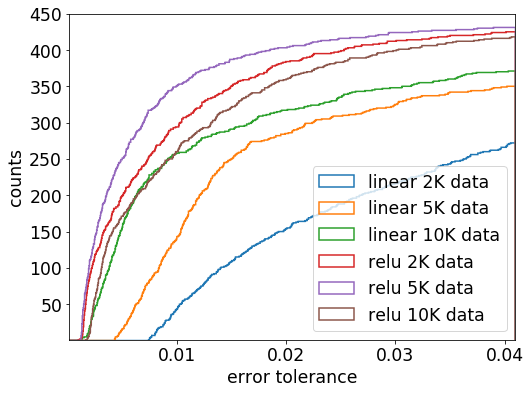

In [16]:
plt.figure(figsize=(8,6))
for i in range(6):
    plt.hist(errorlist[i,:,:].flatten(),bins=np.linspace(0,0.041,1000),cumulative=True,\
         histtype='step',linewidth=1.5,linestyle='-',label=netlist[i][0])
#plt.xticks([0,0.01,0.02,0.03,0.04])
plt.ylabel('counts')
plt.xlabel('error tolerance')
plt.xscale('linear')
plt.legend(loc='lower right')
plt.ylim([1,450])
plt.xlim([1e-4,0.041])
#plt.savefig('./figures/generrorcumul_jnetdt02.eps')

## Parareal iteration

In [6]:
import parareal2
import scipy.io as sio
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

databp = sio.loadmat('bp2004.mat')
datamarm = sio.loadmat('marm1nonsmooth.mat')

In [7]:
#plt.figure(figsize=(18,8))
#plt.imshow(databp['V']);
#plt.colorbar()
#plt.savefig('Full_bp.eps',bbox_inches = "tight")

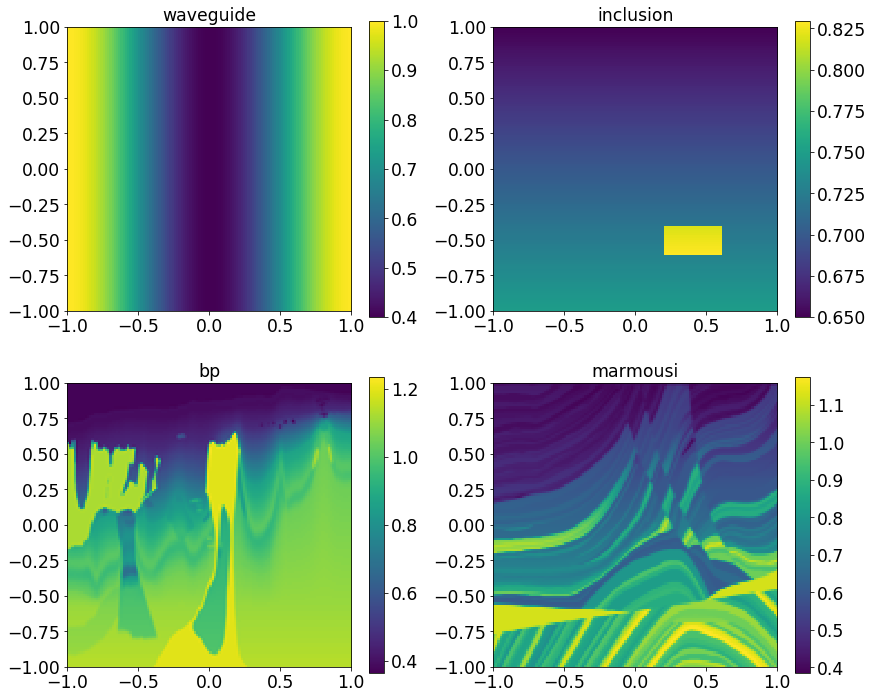

In [7]:
maxiter = 5
Tf = 2.0
cT = 0.25
dx = 2.0/128.0
dt = dx/20
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)
np.random.seed = 21
center = np.array([0,0])

u0 = np.exp(-200.0*((xx-center[0])**2 + (yy-center[1])**2))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
#vel = 0.7-0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1)+0.5*(np.abs(xx-0.2)<0.2)*(np.abs(yy-0.3)<0.1) + 0.2*yy
#vel = 0.7 - 0.3*np.cos(np.pi*xx)
#vel = 1 - 0.3*np.exp(-100*(xx-0.3)**2-50*(yy-0.3)**2)
vel1 = 0.7 - 0.3*np.cos(np.pi*xx)
vel2 = 0.7 + 0.05*yy + 0.1*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #0.3*np.exp(-50*(xx-0.3)**2-20*(yy-0.3)**2)
vel3 = gaussian_filter(resize(databp['Vsmall'],[128,128]),sigma=0)/4
vel4 = gaussian_filter(resize(datamarm['marm1smal'],[128,128]),sigma=0)/4

vellist = (('waveguide',vel1),('inclusion',vel2),('bp',vel3),('marmousi',vel4))

vel = vel1
fig = plt.figure(figsize=(14,12))

ax1 = fig.add_subplot(2,2,1)
subf1 = ax1.imshow(vel1,extent=(-1,1,-1,1))
plt.title('waveguide')
fig.colorbar(subf1)
ax2 = fig.add_subplot(2,2,2)
#subf2 = ax2.imshow(u0)
subf2 = ax2.imshow(vel2,extent=(-1,1,-1,1))
plt.title('inclusion')
fig.colorbar(subf2)
ax3 = fig.add_subplot(2,2,3)
subf3 = ax3.imshow(vel3,extent=(-1,1,-1,1))
plt.title('bp')
fig.colorbar(subf3)
ax4 = fig.add_subplot(2,2,4)
subf4 = ax4.imshow(vel4,extent=(-1,1,-1,1))
plt.title('marmousi')
fig.colorbar(subf4)
#plt.savefig('./testvelmodels.eps',bbox_inches = "tight")

iteration 0
Coarse error: 23.184524744142067
OPP error: 5.746094464526739
iteration 1
Coarse error: 23.623439791462978
OPP error: 5.811011890352168
iteration 2
Coarse error: 25.15467800063671
OPP error: 5.9987292035174224
iteration 3
Coarse error: 25.138729208822664
OPP error: 6.017249705723694
0.25
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 0
Coarse error: 64.96017908154866
OPP error: 11.276084948293992
iteration 1
Coarse error: 60.27566341302864
OPP error: 12.760954073954656
iteration 2
Coarse error: 64.84094617184802
OPP error: 11.90734127901146
iteration 3
Coarse error: 60.56651483417946
OPP error: 10.543985137121775
0.25
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 0
Coarse error: 139.2329411367959
OPP error: 16.228075344927362
iteration 1
Coarse error: 121.76671695013275
OPP error: 19.618824203039186
iteration 2
Coarse error: 133.11955642780873
OPP

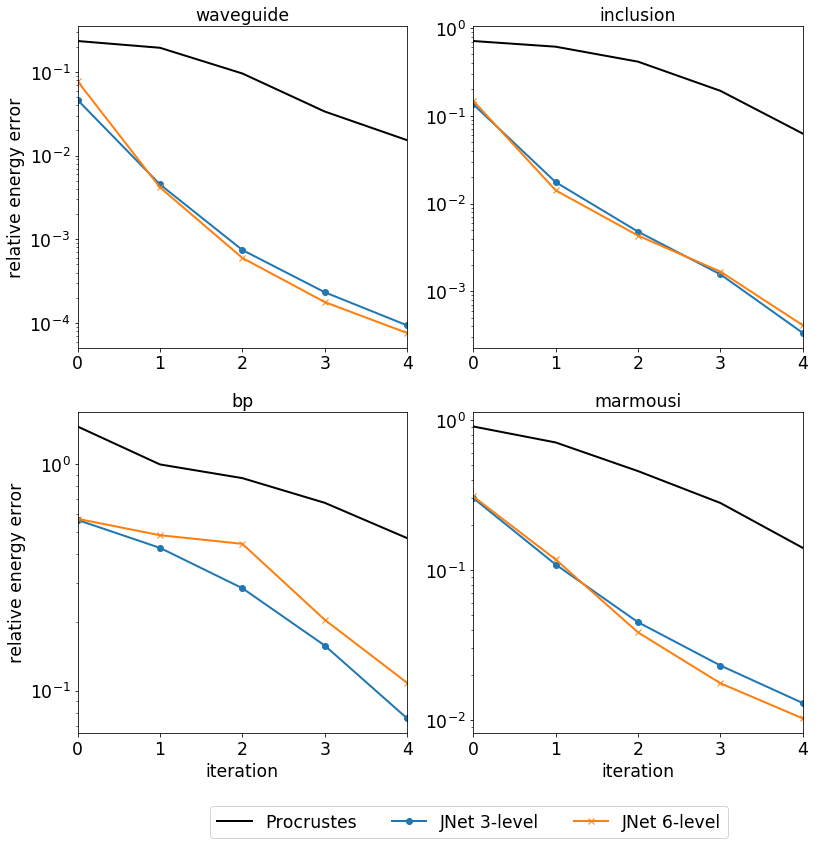

In [9]:
fig1 = plt.figure(figsize=(13,13))
subplotframe = 1

for velname,vel in vellist:
    up,utp = parareal2.parareal2_Procrustes(u0,ut0,vel,dx,dt,cT,m=2,tm=8,T=Tf+cT,pimax=maxiter)
    uexact,utexact,_ = parareal2.InitNetParareal(u0,ut0,vel,dx,dt,cT,1,1,T=Tf+cT,pimax=1)
    
    uev = uexact[:,:,:,0]
    utev = utexact[:,:,:,0]
    
    energy_error = np.zeros(maxiter)
    for piter in range(maxiter):
        diff_field = WaveUtil.WaveEnergyField(up[:,:,-1,piter]-uev[:,:,-1],\
                                            utp[:,:,-1,piter]-utev[:,:,-1],vel,dx)
        normenergy = np.sum(WaveUtil.WaveEnergyField(uev[:,:,-1],utev[:,:,-1],vel,dx))
        energy_error[piter] = np.sum(diff_field)/normenergy
    
    #markerlist = ('k-','--d','--x','--o','-d','-x','-o')
    markerlist = ('k-','-o','-x','-d')
    
    ax1 = fig1.add_subplot(2,2,subplotframe)
    pos1 = ax1.semilogy(energy_error,markerlist[0],linewidth=2,label='Procrustes')
    midx = 1
               
    for netname,modl in netlist:
        #if r'$0.2$' in netname:
        #    cT = 0.2
        #else:
        #    cT = 0.25
        print(cT)
        unn,utnn = parareal2.parareal2_NNpostprocess(u0,ut0,vel,dx,dt,cT,m=2,tm=8,T=Tf+cT,pimax=maxiter,\
                                               net=modl,continue_train=False)
    
        energy_error = np.zeros(maxiter)
        for piter in range(maxiter):
            diff_field = WaveUtil.WaveEnergyField(unn[:,:,-1,piter]-uev[:,:,-1],\
                                                utnn[:,:,-1,piter]-utev[:,:,-1],vel,dx)
            normenergy = np.sum(WaveUtil.WaveEnergyField(uev[:,:,-1],utev[:,:,-1],vel,dx))
            energy_error[piter] = np.sum(diff_field)/normenergy
    
    
        pos1 = ax1.semilogy(energy_error,markerlist[midx],linewidth=2,label=netname)
        midx += 1
        
    plt.xlim([0,maxiter-1])
    #plt.ylim([1e-2,10])
    plt.xticks(np.arange(0,maxiter))
    if subplotframe == 3 or subplotframe == 4: 
        plt.xlabel('iteration')
      
    plt.title(velname)
    if subplotframe == 1 or subplotframe == 3: 
        plt.ylabel('relative energy error')
        
    subplotframe += 1 
    
plt.legend(bbox_to_anchor=(0.8, -0.2),ncol=3)
#plt.savefig('./pararealDvDp_Tcom01_netInit.eps',bbox_inches = "tight")

#### Sequential parareal blocks

0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4
0.25
iteration 1
iteration 2
iteration 3
iteration 4
iteration 1
iteration 2
iteration 3
iteration 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


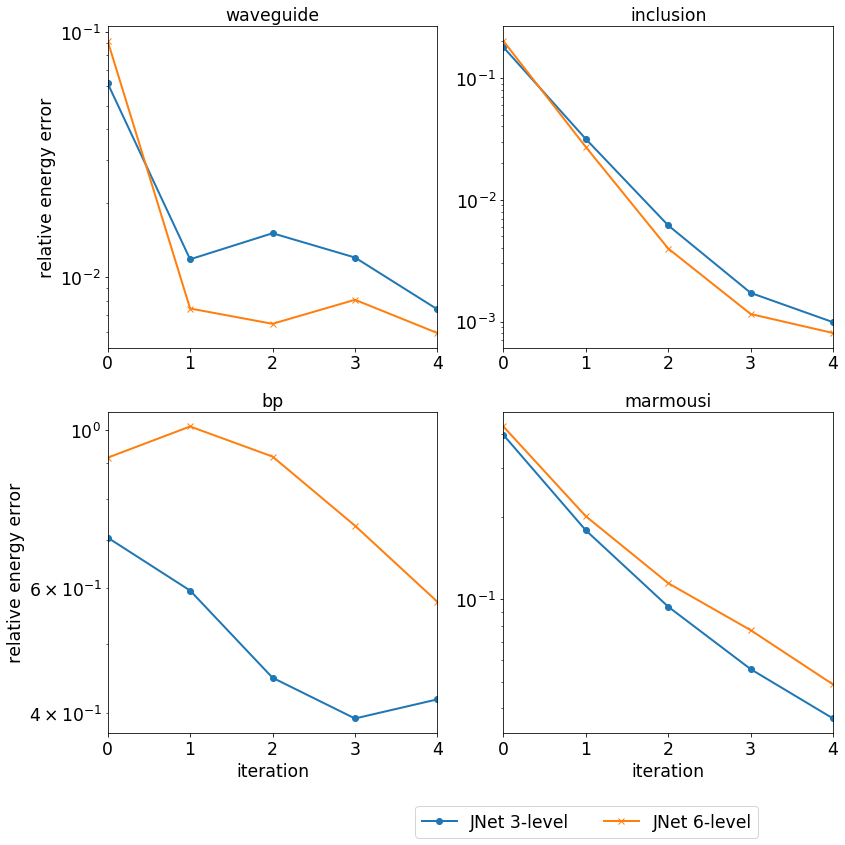

In [15]:
maxiter = 5
Tf = 4.0
Tb = 2.0
mb = int(Tf/Tb)
u0 = np.exp(-200.0*((xx-center[0])**2 + (yy-center[1])**2))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])

fig1 = plt.figure(figsize=(13,13))
subplotframe = 1

for velname,vel in vellist:
    uexact,utexact,_ = parareal2.InitNetParareal(u0,ut0,vel,dx,dt,cT,1,1,T=Tf+cT,pimax=1)
    
    uev = uexact[:,:,:,0]
    utev = utexact[:,:,:,0]
    
    markerlist = ('-o','-x','-d')
    
    ax1 = fig1.add_subplot(2,2,subplotframe)
    midx = 0
    
    for netname,modl in netlist:
        #if r'$0.2$' in netname:
        #    cT = 0.2
        #else:
        #    cT = 0.25
        print(cT)
        unn,utnn = np.zeros(up.shape),np.zeros(up.shape)
        un0 = np.copy(u0)
        utn0 = np.copy(ut0)
        for b in range(mb):
            stidx = b*int(Tb/cT)
            enidx = (b+1)*int(Tb/cT)
            un,utn = parareal2.parareal2_NNpostprocess(un0,utn0,\
                                                       vel,dx,dt,cT,m=2,tm=8,T=Tb+cT,pimax=maxiter,\
                                                       net=modl,continue_train=False) 
            unn[:,:,stidx:enidx,:],utnn[:,:,stidx:enidx,:] = un[:,:,:-1,:],utn[:,:,:-1,:]
            un0 = un[:,:,-1,-1]
            utn0 = utn[:,:,-1,-1]
        unn[:,:,-1,:],utnn[:,:,-1,:] = un[:,:,-1,:],utn[:,:,-1,:]
            
    
        energy_error = np.zeros(maxiter)
        for piter in range(maxiter):
            diff_field = WaveUtil.WaveEnergyField(unn[:,:,-1,piter]-uev[:,:,-1],\
                                                utnn[:,:,-1,piter]-utev[:,:,-1],vel,dx)
            normenergy = np.sum(WaveUtil.WaveEnergyField(uev[:,:,-1],utev[:,:,-1],vel,dx))
            energy_error[piter] = np.sum(diff_field)/normenergy
    
    
        pos1 = ax1.semilogy(energy_error,markerlist[midx],linewidth=2,label=netname)
        midx += 1
        
    plt.xlim([0,maxiter-1])
    #plt.ylim([1e-2,10])
    plt.xticks(np.arange(0,maxiter))
    if subplotframe == 3 or subplotframe == 4: 
        plt.xlabel('iteration')
      
    plt.title(velname)
    if subplotframe == 1 or subplotframe == 3: 
        plt.ylabel('relative energy error')
        
    subplotframe += 1 
    
plt.legend(bbox_to_anchor=(0.8, -0.2),ncol=3)
#plt.savefig('./pararealSeqBlck_Tcom025_netInit.eps',bbox_inches = "tight")